In [1]:
#####
# Packages
##### 

import numpy as np
import pandas as pd 
import tensorflow as tf
#from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## I. Read in dataset 

In [2]:
#sepdatafull = pd.read_csv('wikihowSep.csv')
sepdata = pd.read_csv('wikihowSep.csv')

In [3]:
#sepdata = sepdatafull[:100000]

In [4]:
sepdata.shape

(1585695, 5)

### Examine for NAs 

In [5]:
sepdata.head(5)
# Notice how we have 4 columns: 
# 'overview': the full summary based on the wikihow article 
# 'headline': the "summary" for the paragraph in 'text' column 
# 'text': the actual text of the paragraph 
# 'sectionLabel': section label of the paragraph 
# 'title': the title of which the paragraph belongs to. 

# wikihowSep (downloaded here: https://github.com/mahnazkoupaee/WikiHow-Dataset) is the same file as 
# wikihowAll, except separated by paragraph. 

# Given the length of the documents under wikihowAll, we opted for a shorter summary model to work with where we can 
# take paragraphs, and attempt to generate the headline for the paragraph instead. 

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [6]:
# are there any NA's that we should drop? 
# Note here that we are only concerned about the 3 columns: headline, text, and title 

sepdata_v1 = sepdata.dropna(subset=['headline','text','title'], axis=0).reset_index(drop=True) 
len(sepdata_v1) #yes, we see some NA rows 

1387289

In [7]:
sepdata_v1.head()

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [8]:
# Therefore, how many true titles do we have? 
len(sepdata_v1['title'].unique()) #only 211,825 

211825

In [9]:
# It doesn't quite matter for us since we are trying to predict headline and not the title, 
# but out of curiosity, how many paragraphs on average belong to each title? 
np.nanmean(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values) 
# Roughly 6-7 paragraphs per title 

6.5492222353357725

Text(0.5, 1.0, 'Paragraphs per Article (title)')

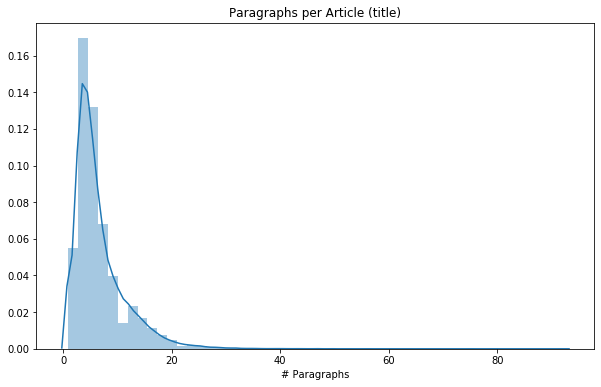

In [10]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,1, figsize = (10,6)) 
sns.distplot(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values, 
            ax=axes, axlabel = '# Paragraphs').set_title('Paragraphs per Article (title)')
# majority of our paragarphsgenerally 

## II. Begin cleaning text of paragraphs 

In [11]:
# Define a text cleaner 
# Drawn heavily with reference from here 
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [12]:
import re #for regex search purposes          
from nltk.corpus import stopwords #stopwords that are provided to us via nltk 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [13]:
# List of contractions that we will map to 

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [70]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: Lower case the text 
    newString = newString.lower()
    # Step 2: Get rid of commas
    #newString = re.sub(r'\([^)]*\)', '', newString)
    # Step 3: Get rid of quotations 
    newString = re.sub('"','', newString)
    # Step 4: get rid of contractions with our contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # Step 5: get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 6: anything that is a number, get rid of it 
    newString = re.sub("\d", " ", newString) 
    # Step 7: separating punctuations so they are their own tokens
    newString = re.sub(r'([,.!;:])', r' \1', newString)

    return newString.split()

In [71]:
# repeat the same step for the headlines, but with some variation on cleaning 

def headline_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: remove quotations 
    newString = re.sub('"','', newString)
    # Step 2: look up contractions 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    # Step 3: Get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 4: Get rid of numbers or anything not in the alphabet
    newString = re.sub("\d", "", newString)
    # Step 5: Lower case 
    newString = newString.lower()
    # Step 7: separating punctuations so they are their own tokens
    newString = re.sub(r'([,.!;:])', r' \1', newString)
    tokens=newString.split()
    return tokens

In [72]:
sepdata_v1.shape

(1387289, 5)

In [73]:
clean_data = pd.DataFrame()

clean_data['text'] = sepdata_v1['text'].apply(text_cleaner)

clean_data['headline'] = sepdata_v1['headline'].apply(headline_cleaner)

In [74]:
clean_data.shape

(1387289, 2)

In [75]:
clean_data['headline'][0]
#Preprocessing has made the text difficult for humans to understand (let alone summarize). Maybe that's the language of the machine. Good luck buddy!


['sell', 'yourself', 'first', '.']

In [77]:
embeddings_index = {}
f = open('data/glove/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [78]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [79]:

def doc2seq(texts, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return data, embedding_matrix, word_index, index_word

In [98]:
MAX_NB_WORDS = 10000
MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 300
data = clean_data.text

x_data, encoder_emb, x_word_index, x_index_word = doc2seq(data, MAX_NB_WORDS, MAX_TEXT_LENGTH, EMBEDDING_DIM)



Found 489940 unique tokens.


In [99]:
MAX_NB_WORDS = 10000
MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
data = clean_data.headline

y_data, decoder_emb, y_word_index, y_index_word = doc2seq(data, MAX_NB_WORDS, MAX_HEADLINE_LENGTH, EMBEDDING_DIM)

Found 129191 unique tokens.


In [100]:
from sklearn.model_selection import train_test_split

In [101]:
x_train, x_test_temp, y_train, y_test_temp = train_test_split(x_data, y_data, 
                                                            test_size=0.3, random_state=0) 

In [102]:
x_dev, x_test, y_dev, y_test = train_test_split(x_test_temp, y_test_temp, 
                                                            test_size=0.33, random_state=0) 

In [103]:
decoder_emb.shape

(129192, 300)

In [104]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention_keras.layers.attention import AttentionLayer

from tensorflow.keras import backend as K 
K.clear_session() 
hidden_units = 250 #this is 600 in the paper. To be changed later.


In [105]:
enc_embedding_layer = Embedding(len(x_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[encoder_emb],
                            input_length=MAX_TEXT_LENGTH,
                            trainable=False,
                            name='EncoderEmbeddingLayer')

In [106]:
dec_embedding_layer = Embedding(len(y_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[decoder_emb],
                            input_length=MAX_HEADLINE_LENGTH,
                            trainable=False,
                            name='DecoderEmbeddingLayer')

In [107]:
# Encoder 

# Encoder input 
# 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
encoder_inputs = Input(shape=(MAX_TEXT_LENGTH,), name="EncoderInput") 
enc_emb = enc_embedding_layer(encoder_inputs) 


#LSTM 1 
encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

#LSTM 4 
encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 

In [108]:
# Decoder 

decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
#dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_embedding_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 


In [109]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 300)     146982300   EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 250), ( 551000      EncoderEmbeddingLayer[0][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 250), ( 501000      EncLSTM1[0][0]                   
______________________________________________________________________________________________

In [92]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [110]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [114]:
history=model.fit([x_train,np.hstack((np.zeros((y_train.shape[0],1)), y_train[:, :-1]))], 
                  y_train,
                  epochs=4,
                  batch_size=160, 
                  validation_data=([x_dev,np.hstack((np.zeros((y_dev.shape[0],1)), y_dev[:, :-1]))], y_dev)
                 )

Train on 971102 samples, validate on 278845 samples
Epoch 1/4
971102/971102 [==============================] - 8042s 8ms/sample - loss: 1.2587 - val_loss: 1.0925
Epoch 2/4
971102/971102 [==============================] - 8062s 8ms/sample - loss: 1.0431 - val_loss: 1.0209
Epoch 3/4
971102/971102 [==============================] - 8084s 8ms/sample - loss: 0.9833 - val_loss: 0.9914
Epoch 4/4
971102/971102 [==============================] - 8086s 8ms/sample - loss: 0.9487 - val_loss: 0.9759


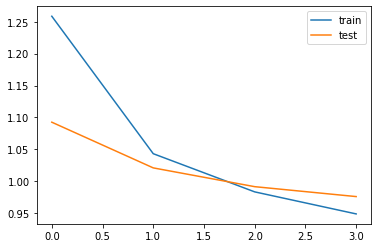

In [115]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [116]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LENGTH,hidden_units))

# Get the embeddings of the decoder sequence
dec_emb2= dec_embedding_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [120]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = y_word_index.get('START', 0)

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        #print(output_tokens)
        #print(h)
        #print(c)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_token = y_index_word.get(sampled_token_index, '.')

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (MAX_HEADLINE_LENGTH-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [154]:
def decode_sequence_beam(input_seq, beam=3):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    top_sentences = {}
    
    def top_tokens(last_token, out, h, c):
        output_tokens, h_new, c_new = decoder_model.predict([[last_token]] + [out, h, c])
        top_token_indexes = np.argsort(output_tokens[0, -1, :])[-beam:]
        top_probabilities = output_tokens[0,-1, top_token_indexes]
        return top_token_indexes, top_probabilities, h_new, c_new
        
    #first set of tokens when feeding encoder states and 0 as the first token to the decoder.
    first_tokens, first_probabilities, h, c = top_tokens(0, e_out, e_h, e_c)
    for first_token, first_probability in zip(first_tokens, first_probabilities):
        #initialize top sentences, their corresponding probabilities and states
        top_sentences[y_index_word.get(first_token, '')] = (first_probability, e_h, e_c)

    #print('Initialized sentences')
    #print(top_sentences.keys())
    
    #loop to iterate over next tokens
    len = 1
    while len < MAX_HEADLINE_LENGTH:
        candidate_sentences = {}
        for sentence, (probability, h, c) in top_sentences.items():
            last_word = sentence.split()[-1] #pick the last word in the sentence as next word
            if(last_word != '.'):
                token = y_word_index.get(last_word, 0) 
                next_tokens, next_probabilities, h_next, c_next = top_tokens(token, e_out, h, c)
                for next_token, next_probability in zip(next_tokens, next_probabilities):
                    new_sentence = sentence.strip() + ' ' + y_index_word.get(next_token, '')
                    candidate_sentences[new_sentence.strip()] = (probability * next_probability, h_next, c_next)

        #print('Candidate sentences')
        #print(candidate_sentences.keys())
        
        #remove low probability candidates
        low_probability_candidates = sorted(candidate_sentences, key=lambda k: candidate_sentences.get(k)[0])[:-beam]
        for low_probability_candidate in low_probability_candidates:
            candidate_sentences.pop(low_probability_candidate)
        
        #Now all candidates left have highest probabilities.
        top_sentences = candidate_sentences
        len = len + 1
        #print('Sentences at the bottom of the loop')
        #print(top_sentences.keys())
        

    return top_sentences

In [118]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0 ):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [196]:
res = decode_sequence_beam(x_test[2000].reshape(1,-1), 5)

In [197]:
l = [(sen, prob) for sen, (prob, _, _) in res.items()]
    

In [198]:
sorted(l, key = lambda x:-x[1])

[('pull the boat off the top of the boat with a fork and hold the boat up to the top of the boat and place it on the boat .',
  5.5992517e-19),
 ('pull the boat off the top of the boat with a fork and hold the boat up to the top of the boat and place the boat on the boat',
  2.8316683e-19),
 ('pull the boat off the top of the boat with a fork and hold the boat up to the top of the boat and place the boat on the ground',
  2.31176e-19),
 ('pull the boat off the top of the boat with a fork and hold the boat up to the top of the boat and place the boat in the boat',
  2.2558562e-19),
 ('pull the boat off the top of the boat with a fork and hold the boat up to the top of the boat and place it in the boat .',
  1.7532938e-19)]

In [127]:
for i in range(100, 110):
    print(decode_sequence(x_test[i].reshape(1,-1)))
    print(seq2summary(y_test[i]))
    print(seq2text(x_test[i]))
    print('______________________________________')

 pour the mixture into the pan . . . . . . . . . . . . . . . . . . . . . . .
when the pastry is cooked and the sugar is nice and golden , remove carefully from the oven and cool in dish . 
the filling will set as it cools . 
______________________________________
 click on the button . . . . . . . . . . . . . . . . . . . . . . . . .
look for the contact info section . 
the previous step should land you on the about page of your account . you will not miss it as it will have the word displayed at the top , but just below your profile picture . scroll down slowly through the sections until you see info .” 
______________________________________
 research your market . . . . . . . . . . . . . . . . . . . . . . . . . .
your textbooks . 
the year . however , prices there tend to be low . you can try your books on your own . you may get more money going this route .the website will give you an idea of how much a specific used book tends to sell for . you can then try to sell the book online 

In [190]:
# serialize model to JSON
model_json = model.to_json()
with open("model_fd_111319_250units_punct.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_fd_111319_250units_punct.h5")
print("Saved model to disk")

Saved model to disk


In [93]:
model.load_weights("model_full_data_111019.h5")


In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('model_full_data_111019.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_from_disk = model_from_json(loaded_model_json)

